# Webcam Painting

In [1]:
import ipywidgets
import numpy as np
import cv2 as cv
from PIL import Image

## Setting up a webcam

In [2]:
from io import BytesIO
import IPython.display
import PIL.Image

def camera_capture():
    camera = cv.VideoCapture(0)
    camera.set(3, 640)
    camera.set(4, 480)
    ret, image = camera.read()

    if not ret:
        return None

    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    camera.release()
    return image

def camera_stream(process=lambda frame: frame):
    camera = cv.VideoCapture(0)
    camera.set(3, 1280)
    camera.set(4, 1024)
    try: 
        while True:
            ret, frame = camera.read()
            frame = cv.flip(frame, 0)
            frame = process(frame)
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

            stream = BytesIO()
            PIL.Image.fromarray(frame).save(stream, format="jpeg")
            IPython.display.display(IPython.display.Image(data=stream.getvalue()))

            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        camera.release()
        print("Stream Stopped")

In [3]:
# Image.fromarray(camera_capture())

## Finding HSV ranges for highlighters

In [4]:
def find_hsv_ranges():
    cv.namedWindow("Controls")
    cv.resizeWindow("Controls", 640, 350)
    cv.createTrackbar("Min H", "Controls", 0, 200, lambda _: None)
    cv.createTrackbar("Max H", "Controls", 0, 200, lambda _: None)
    cv.createTrackbar("Min S", "Controls", 0, 255, lambda _: None)
    cv.createTrackbar("Max S", "Controls", 0, 255, lambda _: None)
    cv.createTrackbar("Min V", "Controls", 0, 255, lambda _: None)
    cv.createTrackbar("Max V", "Controls", 0, 255, lambda _: None)

    img0 = cv.imread("colors0.png")
    img1 = cv.imread("colors1.png")
    img = np.vstack((img0, img1))
    img = cv.GaussianBlur(img, (11, 11), 10)
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

    color = ipywidgets.Label()
    display(color)

    while True:
        h0 = cv.getTrackbarPos("Min H", "Controls")
        h1 = cv.getTrackbarPos("Max H", "Controls")
        s0 = cv.getTrackbarPos("Min S", "Controls")
        s1 = cv.getTrackbarPos("Max S", "Controls")
        v0 = cv.getTrackbarPos("Min V", "Controls")
        v1 = cv.getTrackbarPos("Max V", "Controls")

        mask = cv.inRange(hsv, (h0, s0, v0), (h1, s1, v1))
        vision = cv.bitwise_and(img, img, mask=mask)

        cv.imshow("Preview", np.hstack((img, vision)))

        k = cv.waitKey(1)
        if k != -1:
            break
        color.value = f"({h0}, {s0}, {v0}), ({h1}, {s1}, {v1})"

    cv.destroyAllWindows()

In [5]:
# find_hsv_ranges()

In [17]:
orange = (1, 143, 141), (11, 255, 255)
yellow = (17, 103, 141), (36, 255, 255)
green = (61, 103, 101), (71, 255, 255)
magenta = (164, 143, 141), (174, 255, 255)

In [7]:
# orange = (0, 163, 120), (15, 255, 255)
# yellow = (36, 117, 95), (55, 255, 255)
# green = (55, 109, 127), (96, 255, 255)
# magenta = (156, 102, 128), (168, 255, 255)

## Detecting colors of the highlighters

In [8]:
def get_masks(frame):
    frame = cv.GaussianBlur(frame, (11, 11), 10)
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)

    orange_mask = cv.inRange(hsv, orange[0], orange[1])
    yellow_mask = cv.inRange(hsv, yellow[0], yellow[1])
    green_mask = cv.inRange(hsv, green[0], green[1])
    magenta_mask = cv.inRange(hsv, magenta[0], magenta[1])

    return (orange_mask, yellow_mask, green_mask, magenta_mask)

def display_masks(frame):
    orange_mask, yellow_mask, green_mask, magenta_mask = get_masks(frame)
    # mask = cv.bitwise_or(cv.bitwise_or(orange_mask, yellow_mask),
    #                      cv.bitwise_or(green_mask, magenta_mask))
    # vision = cv.bitwise_and(frame, frame, mask=mask)
    orange_mask = np.repeat(orange_mask[:, :, np.newaxis], 3, axis=2)
    yellow_mask = np.repeat(yellow_mask[:, :, np.newaxis], 3, axis=2)
    green_mask = np.repeat(green_mask[:, :, np.newaxis], 3, axis=2)
    magenta_mask = np.repeat(magenta_mask[:, :, np.newaxis], 3, axis=2)
    return np.vstack((np.hstack((frame, yellow_mask)),
                      np.hstack((green_mask, magenta_mask))))

In [9]:
# camera_stream(process=display_masks)

In [10]:
orange_paint = (0, 127, 255)
yellow_paint = (0, 255, 255)
green_paint = (0, 255, 0)
magenta_paint = (255, 0, 255)

In [11]:
def get_boundings(frame):
    masks = get_masks(frame)
    colors = [orange_paint, yellow_paint, green_paint, magenta_paint]

    boundings = set({})
    for mask, color in zip(get_masks(frame), colors):
        contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
        for contour in contours:
            area = cv.contourArea(contour)
            if area > 300:
                # approx = cv.approxPolyDP(contour, cv.arcLength(contour, True) * 0.05, True)
                # cv.drawContours(frame, [approx], -1, color, 3, cv.LINE_AA)
                # cv.drawContours(frame, contour, -1, color, 3, cv.LINE_AA)
                boundings.add((color, cv.boundingRect(contour)))
    return boundings 

def display_boundings(frame):
    boundings = get_boundings(frame)
    for (color, rect) in boundings:
        x, y, w, h = rect
        cv.rectangle(frame, (x, y), (x + w, y + h), color, 2)
    return frame

In [12]:
# camera_stream(process=display_boundings)

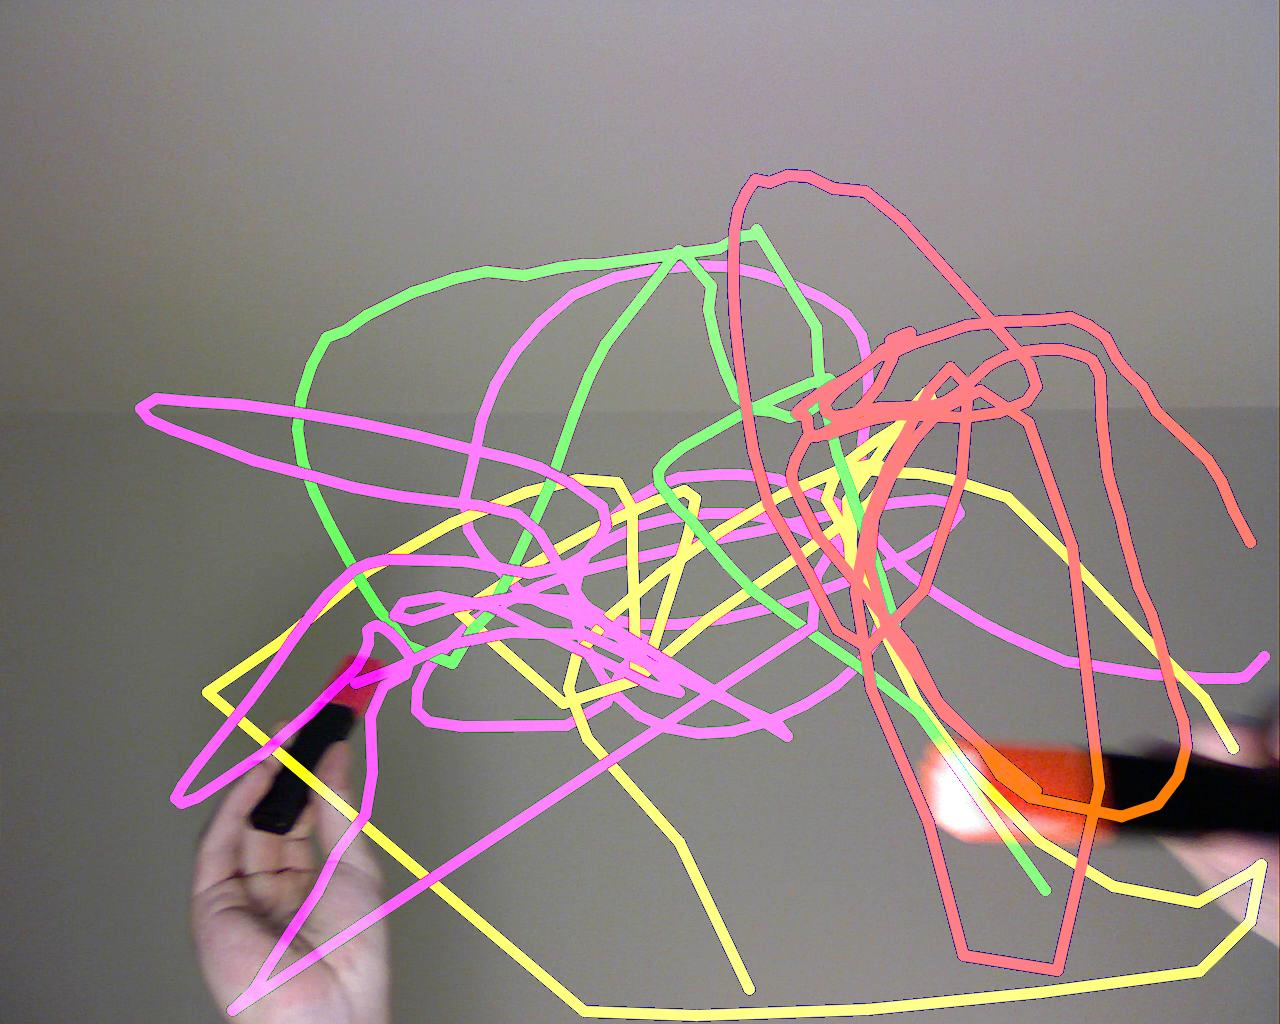

In [ ]:
drawing = np.zeros((1024, 1280, 3), np.uint8)
last_dots = {}

def display_drawing(frame):
    global drawing, last_dots
    boundings = get_boundings(frame)
    for (color, rect) in boundings:
        x, y, w, h = rect
        dot = (w // 2 + x, h // 2 + y)
        if last_dots.get(color) is not None:
            cv.line(drawing, last_dots[color], dot, color, 10, cv.LINE_AA)
        else:
            cv.line(drawing, dot, dot, color, 10, cv.LINE_AA)
        last_dots[color] = dot

    cond = drawing != 0
    frame[cond] = drawing[cond]
    return frame

camera_stream(process=display_drawing)